In [1]:
import matplotlib.pyplot as plt
from face_swap.image_preprocessing import *
from face_swap.utils import *
from face_swap.keypoints import *
import tqdm.notebook as tq

In [2]:
source_img_path = "data/f1.jpg"
target_img_path = "data/macron2.jpg"

source_img = read_image(source_img_path)
target_img = read_image(target_img_path)

s_aligned, s_ldmks = get_aligned_image(source_img)
t_aligned, t_ldmks = get_aligned_image(target_img)

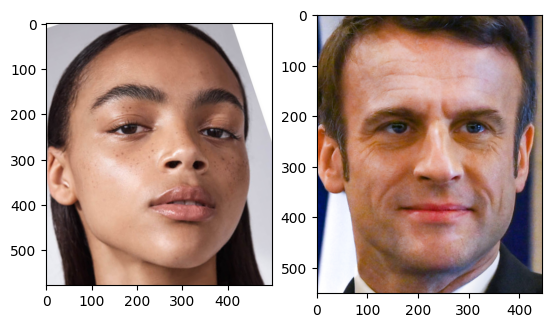

In [3]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(s_aligned)
axarr[1].imshow(t_aligned)

In [11]:

mixed_clone = t_aligned.copy()
added1 = np.zeros(t_aligned.shape, np.uint8)
added2 = np.zeros(t_aligned.shape, np.uint8)

for i in range(0, int(len(TRIANGULATION) / 3)):
    points = [TRIANGULATION[i * 3], TRIANGULATION[i * 3 + 1], TRIANGULATION[i * 3 + 2]]
    s_zone_ldmks = get_zone_landmarks(points, s_ldmks)
    t_zone_ldmks = get_zone_landmarks(points, t_ldmks)

    s_zone_patch = get_patch_image(s_aligned, points, s_ldmks)
    t_zone_patch = get_patch_image(t_aligned, points, t_ldmks)

    rotation_matrix, _ = cv2.estimateAffinePartial2D(s_zone_ldmks, t_zone_ldmks)
    s_rotated = cv2.warpAffine(
        s_zone_patch, 
        rotation_matrix, 
        (t_zone_patch.shape[1], t_zone_patch.shape[0])
        )
    
    added1 = cv2.add(added1, s_rotated)

    # t_zone_mask = t_zone_patch[:, :, 0]
    # s_masked = cv2.bitwise_and(s_rotated, s_rotated, mask=t_zone_mask)
    
    t_zone_mask =( t_zone_patch[:, :, 0] > 0).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    smoothed_mask = cv2.morphologyEx(t_zone_mask, cv2.MORPH_OPEN, kernel)
    smoothed_mask = cv2.GaussianBlur(smoothed_mask, (15, 15), 0)
    s_masked = cv2.bitwise_and(s_rotated, s_rotated, mask=t_zone_mask)

    added2 = cv2.add(added2, s_masked)

    t_scale_ldmks = get_zone_landmarks(points, t_ldmks)
    # center_x = (np.max(t_scale_ldmks[:, 0]) + np.min(t_scale_ldmks[:, 0])) // 2
    # center_y = (np.max(t_scale_ldmks[:, 1]) + np.min(t_scale_ldmks[:, 1])) // 2
    h, w = s_masked.shape[:2]

    # 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows

    # mixed_clone = cv2.seamlessClone(
    #     s_masked, 
    #     mixed_clone, 
    #     s_masked[:, :, 0], 
    #     (w // 2, h // 2), 
    #     cv2.MIXED_CLONE
    #     )
    

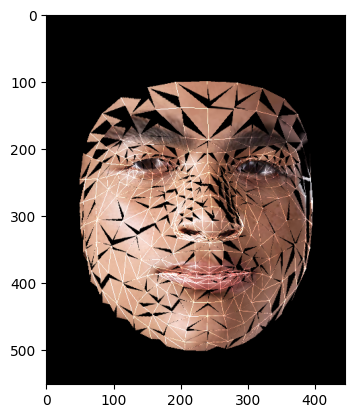

In [12]:
plt.imshow(added2)

In [13]:
mixed_clone = cv2.seamlessClone(
    added2, 
    t_aligned, 
    added2[:, :, 1], 
    (added2.shape[1] // 2, added2.shape[0] // 2), 
    cv2.MIXED_CLONE
)

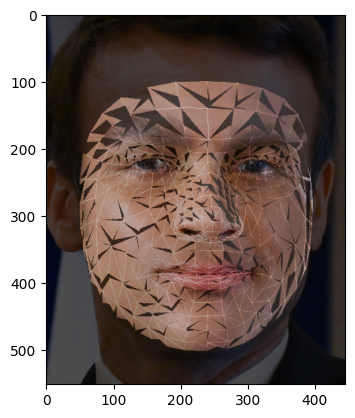

In [14]:
add = cv2.addWeighted(t_aligned, 0.3, added2, 0.5, 0)
plt.imshow(add)

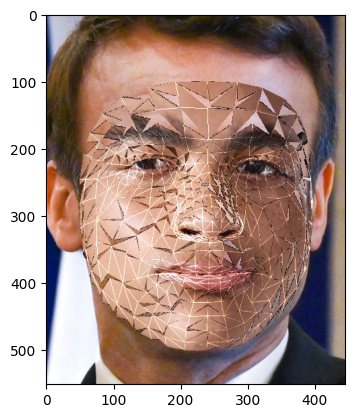

In [15]:
final_mask = (added2.sum(axis = 2) == 0).astype(np.uint8)
orig = cv2.bitwise_and(t_aligned, t_aligned, mask=final_mask)
res = cv2.add(orig, added2)

plt.imshow(res)

In [16]:
mixed_clone = cv2.seamlessClone(
    res, 
    t_aligned, 
    cv2.bitwise_not(final_mask), 
    (added2.shape[1] // 2, added2.shape[0] // 2), 
    cv2.MIXED_CLONE
)

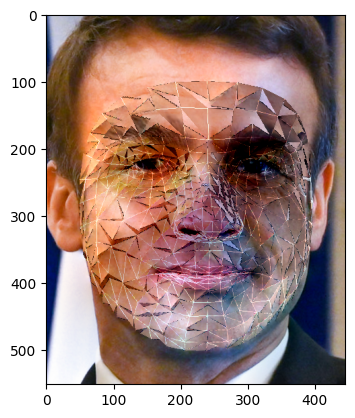

In [17]:
plt.imshow(mixed_clone)